In [2]:
# Bibliotecas utilizadas

# Treinamento do modelo
from torch import cuda
import random
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Plot dos gráficos
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [3]:
# Define a semente para reprodutibilidade
seed_value = 1

# Definindo a semente de hash do Python
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Define a semente para o módulo random do Python
random.seed(seed_value)

# Define a semente para o NumPy
np.random.seed(seed_value)

# Define a semente para o TensorFlow
tf.random.set_seed(seed_value)

In [4]:
# Checagem do seed
current_seed = np.random.get_state()[1][0]
print(f"Current NumPy seed: {current_seed}")

Current NumPy seed: 1


In [5]:
# Caminho do Dataset
dataset_path = r'D:\USER DATA NAO APAGAR\Desktop\Unifesp\2024 - 1 - semestre\IA\projeto\datasetnovo'

# Carregamento do Dataset
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),  # Redimensiona as imagens para 224x224 
    batch_size=32,  # Processa as imagens em batches de 32
    shuffle=True  # Embaralha os dados para melhor aleatoriedade 
)

Found 2100 files belonging to 14 classes.


In [6]:
# Verificar a disponibilidade da GPU e utilizá-la, se houver
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')


if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [13]:
# Vericar quantas classes tem o dataset
class_names = full_dataset.class_names


num_classes = len(class_names)
print(f"Number of classes: {num_classes}")


print("Class names:", class_names)

Number of classes: 14
Class names: ['BICICLETA', 'BOMBEIRO', 'CAFE', 'CARNE', 'CASA', 'ESCOLA', 'HELICOPTERO', 'HOSPITAL', 'MANTEIGA', 'MOTOCICLETA', 'PAO', 'RESTAURANTE', 'TOMATE', 'TREM']


In [14]:
# Calcula o número de batches no dataset
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()

# Faz a divisão dos sets (70%, 15% e 15%)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

In [15]:
# Cria o set de treinamento
train_dataset = full_dataset.take(train_size)

# Cria o set de validação
val_dataset = full_dataset.skip(train_size).take(val_size)

# Cria o set de teste
test_dataset = full_dataset.skip(train_size + val_size)

In [16]:
# Imprime o tamanho de cada set
print(test_size)
print(train_size)
print(val_size)


11
46
9


In [28]:
# Carrega o modelo InceptionResNetV2 pré-treinado com os pesos ImageNet 
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224, 224, 3),
                                                     include_top=False,  # Exclude the final classification layers
                                                     weights='imagenet')

# Congela as camadas do modelo base, prevenindo de serem treinados
base_model.trainable = False

# É Adicionado uma camada de Global Average Pooling e de seu próprio classificador
model = tf.keras.Sequential([
    base_model,  
    tf.keras.layers.GlobalAveragePooling2D(),  # Achata as características
    tf.keras.layers.Dense(1024, activation='relu'),  # Adicionado camadas densas para classificação personalizada
    tf.keras.layers.Dropout(0.5),  # Adicionado dropout para prevenir overfitting
    tf.keras.layers.Dense(num_classes, activation='softmax')  
])


# Compilação do modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

In [29]:
# Usado para guardar os pesos de cada época treinada

# Diretório usado para guardar os pesos
checkpoint_dir = r'D:\USER DATA NAO APAGAR\Desktop\Unifesp\2024 - 1 - semestre\IA\projeto\modelos\Inception'

os.makedirs(checkpoint_dir, exist_ok=True)

# Definição do callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_InceptionResNetV2_model.keras'),  # Salva no file path o melhor modelo
    monitor='val_accuracy',    
    save_best_only=True,       
    save_weights_only=False,   
    mode='max',               
    verbose=1                  
)

In [30]:
# Diretório usado para guardar o histórico
history_dir = r'D:\USER DATA NAO APAGAR\Desktop\Unifesp\2024 - 1 - semestre\IA\projeto\modelos\Inception'

# Cria o diretório se ele não existir
os.makedirs(history_dir, exist_ok=True)

# Caminho completo para o arquivo de histórico
history_path = os.path.join(history_dir, 'history_InceptionResNetV2.pkl')

In [31]:
# Treinamento do modelo
num_epochs = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint_callback],
    epochs=num_epochs  
)

# Salvando o histórico
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)



Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0575 - loss: 287.5234
Epoch 1: val_accuracy improved from -inf to 0.06944, saving model to D:\USER DATA NAO APAGAR\Desktop\Unifesp\2024 - 1 - semestre\IA\projeto\modelos\Inception\best_InceptionResNetV2_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.0577 - loss: 284.4670 - val_accuracy: 0.0694 - val_loss: 2.6390
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0583 - loss: 2.6392
Epoch 2: val_accuracy did not improve from 0.06944
46/46 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.0585 - loss: 2.6392 - val_accuracy: 0.0521 - val_loss: 2.6391
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0620 - loss: 2.6391
Epoch 3: val_accuracy did not improve from 0.06944
46/46 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.0623 - loss: 2.6391 - val_accuracy: 0.0625 - val_loss: 2.6395
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0613 - loss: 2.6392
Epoch 4: val_accuracy

# Carregar Modelo Salvo

In [8]:
# Caso precise usar o modelo salvo

# Diretório usado para guardar o modelo
model_dir = r'D:\USER DATA NAO APAGAR\Desktop\Unifesp\2024 - 1 - semestre\IA\projeto\modelos\Inception'

model_path = model_dir + '/best_InceptionResNetV2_model.keras'

# Carrega modelo salvo
model = load_model(model_path)

In [11]:
# Diretório usado para guardar o histórico
history_dir = r'D:\USER DATA NAO APAGAR\Desktop\Unifesp\2024 - 1 - semestre\IA\projeto\modelos\Inception'
history_path = history_dir + '\history_InceptionResNetV2.pkl'

# Carregue o histórico salvo
with open(history_path, 'rb') as f:
    history = pickle.load(f)

<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
C:\Users\USER-64\AppData\Local\Temp\ipykernel_14288\2759479902.py:3: SyntaxWarning: invalid escape sequence '\h'
  history_path = history_dir + '\history_InceptionResNetV2.pkl'


# Plot dos Gráficos

In [17]:
# Obtem as previsões
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_prob = model.predict(test_dataset)

# Converte as previsões em rótulos de classe, se necessário
y_pred = np.argmax(y_pred_prob, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step


In [18]:
# Carrega o arquivo CSV com todas rótulos da base de dados utilizada
labels_df = pd.read_csv('labels.csv')  

# Extrair as rótulos em uma lista
class_labels = labels_df['LABEL'].tolist()

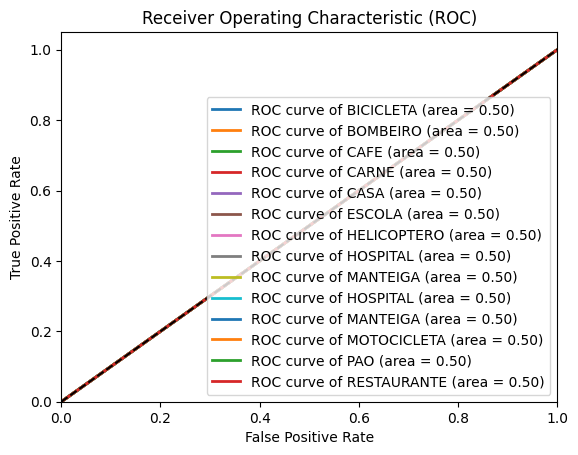

In [19]:
# Binariza os rótulos
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))  

# Computa a curva ROC e a área ROC para cada classe
fpr = dict()  # Taxa de Falsos Positivos
tpr = dict()  # Taxa de Verdadeiros Positivos
roc_auc = dict()  # Área sob a curva ROC

for i in range(num_classes): 
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plota todas as curvas ROCs
plt.figure()
for i in range(num_classes):
    label_name = class_labels[i] 
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of {label_name} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

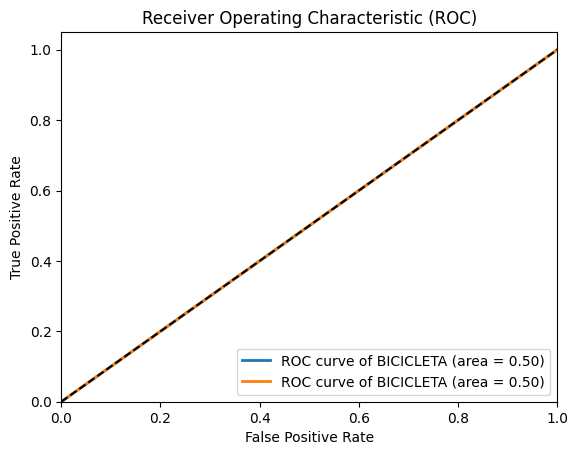

In [20]:
# Identifica a classe com a maior e a menor área ROC
max_auc_class = max(roc_auc, key=roc_auc.get)
min_auc_class = min(roc_auc, key=roc_auc.get)

# Plota as curvas ROC para a classe com a maior e a menor área
plt.figure()
for i in [max_auc_class, min_auc_class]:
    label_name = class_labels[i] 
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of {label_name} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Inicializa dicionários para armazenar precisão, recall e precisão média para cada classe
precision = precision_score(y_true, y_pred, average=None)  # Precisão de cada classe
recall = recall_score(y_true, y_pred, average=None)
for i in range(num_classes):
    label_name = class_labels[i]
    print(f'Class {label_name}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}')

Class BICICLETA: Precision = 0.00, Recall = 0.00
Class BOMBEIRO: Precision = 0.00, Recall = 0.00
Class CAFE: Precision = 0.00, Recall = 0.00
Class CARNE: Precision = 0.00, Recall = 0.00
Class CASA: Precision = 0.00, Recall = 0.00
Class ESCOLA: Precision = 0.00, Recall = 0.00
Class HELICOPTERO: Precision = 0.00, Recall = 0.00
Class HOSPITAL: Precision = 0.07, Recall = 1.00
Class MANTEIGA: Precision = 0.00, Recall = 0.00
Class HOSPITAL: Precision = 0.00, Recall = 0.00
Class MANTEIGA: Precision = 0.00, Recall = 0.00
Class MOTOCICLETA: Precision = 0.00, Recall = 0.00
Class PAO: Precision = 0.00, Recall = 0.00
Class RESTAURANTE: Precision = 0.00, Recall = 0.00


c:\Users\USER-64\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


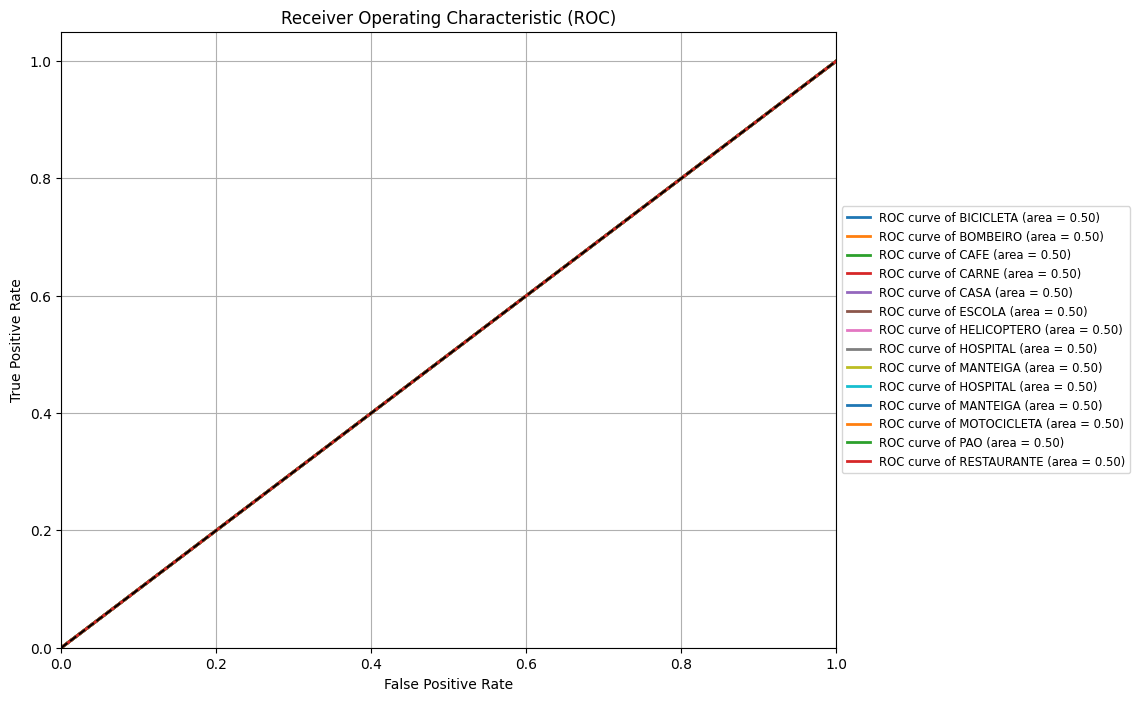

In [22]:
# Plota todas as curvas ROC
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    label_name = class_labels[i]  
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of {label_name} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')

# Coloca a legenda na parte de fora do gráfico
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.grid(True)
plt.show()


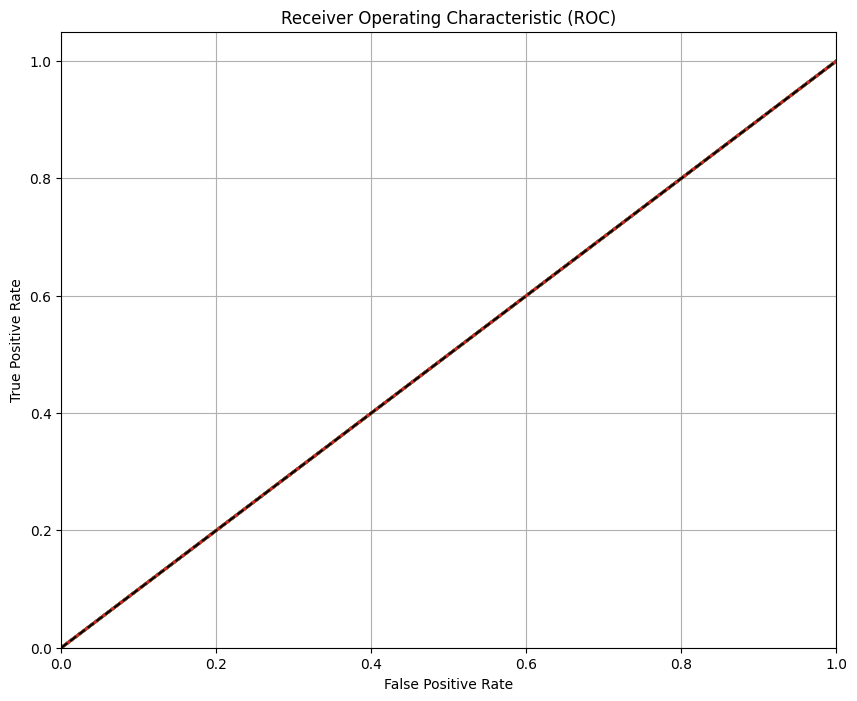

In [23]:
# Plota todas as curvas ROC sem legenda
plt.figure(figsize=(10, 8))
for i in range(num_classes):  
    plt.plot(fpr[i], tpr[i], lw=2)  

plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.grid(True)
plt.show()


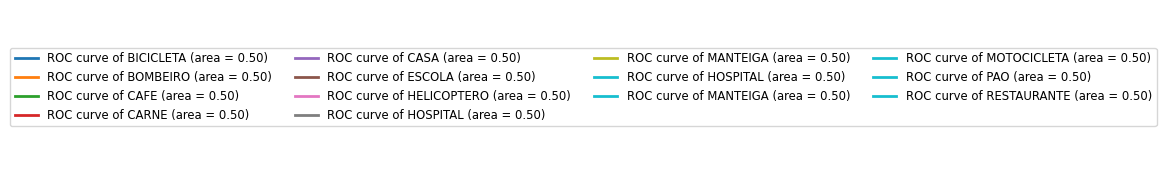

In [24]:
# Cria uma nova figura para a legenda
fig_legend, ax = plt.subplots(figsize=(10, 2))

# Oculta os eixos
ax.axis('off')

# Cria linhas com cores correspondentes de um mapa de cores
legend_lines = [Line2D([0], [0], color=plt.get_cmap('tab10')(i), lw=2) for i in range(num_classes)]

# Adiciona uma legenda à figura com rótulos do CSV
ax.legend(
    legend_lines,
    [f'ROC curve of {class_labels[i]} (area = {roc_auc[i]:.2f})' for i in range(num_classes)],  # Rótulos de cada classe
    loc='center', ncol=4, fontsize='small'
)

plt.show()

In [ ]:
# Dados reais do treinamento
epochs = np.arange(1, len(history.history['accuracy'])+1)  

# Extrai dados de acurácia e perda do histórico
train_accuracy = history.history['accuracy']  # Valores de acurácia do treinamento
val_accuracy = history.history['val_accuracy']  # Valores de acurácia da validação
train_loss = history.history['loss']  # Valores de perda do treinamento
val_loss = history.history['val_loss']  # Valores de perda da validação

# Plot da Acurácia
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot da Perda
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


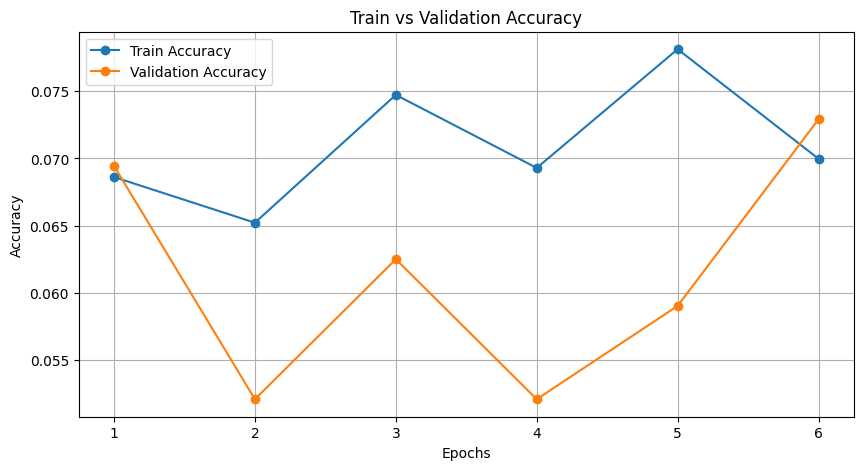

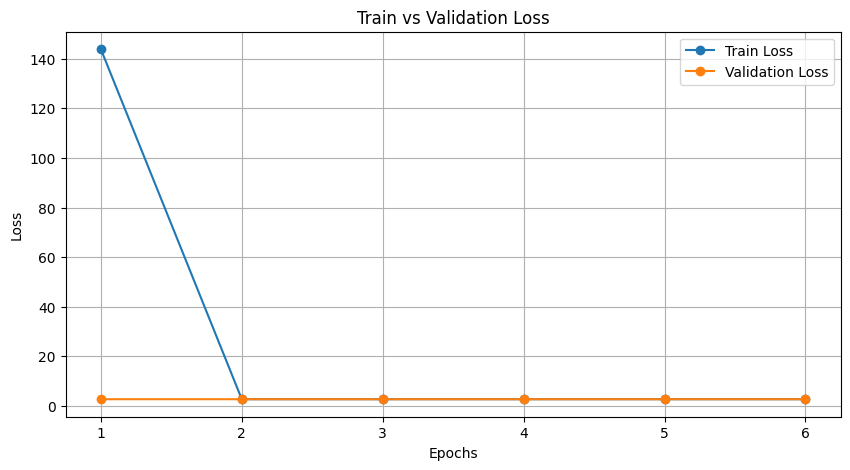

In [29]:
# Para Caso tenha que carregado o histórico, use este código
# Dados reais do treinamento
epochs = np.arange(1, len(history['accuracy'])+1)  

# Extrai dados de acurácia e perda do histórico
train_accuracy = history['accuracy']  # Valores de acurácia do treinamento
val_accuracy = history['val_accuracy']  # Valores de acurácia da validação
train_loss = history['loss']  # Valores de perda do treinamento
val_loss = history['val_loss']  # Valores de perda da validação

# Plot da Acurácia
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot da Perda
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()